In [11]:
import torch
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm, trange

# # Importing the project from a subfolder
# sys.path.append('./project')

from models.transformer import Aggregator
from models.tokenizer import Tokenizer
from models.vggt import VGGT, unflatten_tokens
from heads.camera_head import CameraHead

from dataloader.projection import *
from dataloader.dataset import *

# Main training test

In [2]:
# can I even load the big one
path = "/sdf/home/y/youngsam/data/dune/larnet/h5/DataAccessExamples/train/generic_v2_51800_v1.h5"
dataset = dataset_from_file(path)

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loaded {len(dataset)} events")

Loaded 51800 events


In [71]:
# Initialize model and associated optimizer
model = VGGT()
model = model.to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

i = 0

history = list()

In [72]:
print_every = 100
for _ in range(1000):
    # Take a sample
    start = time.perf_counter()
    sample, _, rotations = dataset.choose_events(50, 3)
    patch_counts, all_coords, all_patches = stack_patches(sample)
    patch_counts = torch.Tensor(patch_counts).int().to(device)
    all_coords = torch.Tensor(all_coords).int().to(device)
    all_patches = torch.Tensor(all_patches).to(device)

    # Zero gradients
    optimizer.zero_grad()
    
    # Make predictions
    predictions, test_output, patch_start_idx = model(patch_counts, all_coords, all_patches)
    pred_quaternions = predictions["pose_enc"]

    # Compute the ground truth
    inverse_first = [x[0].inv() for x in rotations]
    corrected_rotations = [[x*first for x in row] for first, row in zip(inverse_first, rotations)]
    quaternions = torch.tensor(np.array([[r.as_quat() for r in row] for row in corrected_rotations])).to(device).float()
    
    # Run backprop
    loss = loss_fn(pred_quaternions, quaternions)
    loss.backward()
    optimizer.step()
    end = time.perf_counter()
    
    if i % print_every == 0:
        # Print loss
        print(f"i={i}, loss={loss.item()}, time={end-start}s")

    history.append(loss.item())
    
    i += 1

i=0, loss=0.5917493104934692, time=2.71808048710227s
i=100, loss=0.21429072320461273, time=2.8217551931738853s
i=200, loss=0.1667589545249939, time=2.7829651068896055s
i=300, loss=0.16798357665538788, time=2.6582535039633512s
i=400, loss=0.16899068653583527, time=2.5419488716870546s
i=500, loss=0.16726580262184143, time=2.231698350980878s
i=600, loss=0.1667259782552719, time=2.4078102130442858s
i=700, loss=0.1701100468635559, time=2.5902597159147263s
i=800, loss=0.1750008463859558, time=2.6314047314226627s
i=900, loss=0.1676492989063263, time=2.56325888261199s


In [66]:
# Take sample
sample, _, rotations = dataset.choose_events(2, 3)
patch_counts, all_coords, all_patches = stack_patches(sample)
patch_counts = torch.Tensor(patch_counts).int().to(device)
all_coords = torch.Tensor(all_coords).int().to(device)
all_patches = torch.Tensor(all_patches).to(device)

# Make predictions
predictions, test_output, patch_start_idx = model(patch_counts, all_coords, all_patches)
pred_quaternions = predictions["pose_enc"]

# Compute the ground truth
inverse_first = [x[0].inv() for x in rotations]
corrected_rotations = [[x*first for x in row] for first, row in zip(inverse_first, rotations)]
quaternions = torch.tensor(np.array([[r.as_quat() for r in row] for row in corrected_rotations])).to(device).float()

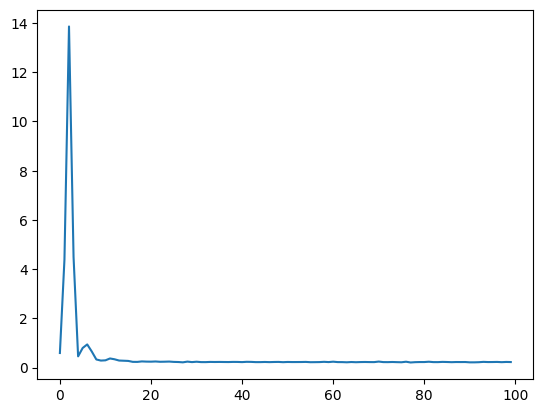

In [75]:
plt.plot(history[:100])

# Timing the training

In [30]:
# Function to gauge how long it takes to do each step v.s. time

Ns = [1, 5, 10, 20, 30, 40, 60, 80, 100]
reps = 30
results = list()

for N in Ns:
    model = VGGT()
    model = model.to(device)
    
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    sub_results = list()

    for _ in trange(reps):        
        # Take a sample
        sample_start = time.perf_counter()
        sample, _, rotations = dataset.choose_events(N, 3)
        patch_counts, all_coords, all_patches = stack_patches(sample)
        patch_counts = torch.Tensor(patch_counts).int().to(device)
        all_coords = torch.Tensor(all_coords).int().to(device)
        all_patches = torch.Tensor(all_patches).to(device)
        sample_end = time.perf_counter()
    
        # Zero gradients
        optimizer.zero_grad()
        
        # Make predictions
        pred_start = time.perf_counter()
        predictions, test_output, patch_start_idx = model(patch_counts, all_coords, all_patches)
        pred_quaternions = predictions["pose_enc"]
        pred_end = time.perf_counter()
    
        # Compute the ground truth
        quaternions = torch.tensor(np.array([[r.as_quat() for r in row] for row in rotations])).to(device).float()
        
        # Run backprop
        backprop_start = time.perf_counter()
        loss = loss_fn(pred_quaternions, quaternions)
        loss.backward()
        optimizer.step()
        backprop_end = time.perf_counter()

        sub_results.append((sample_end-sample_start, pred_end-pred_start, backprop_end-backprop_start))
    results.append(sub_results)

100%|██████████| 30/30 [02:39<00:00,  5.31s/it]


In [31]:
results = np.array(results)

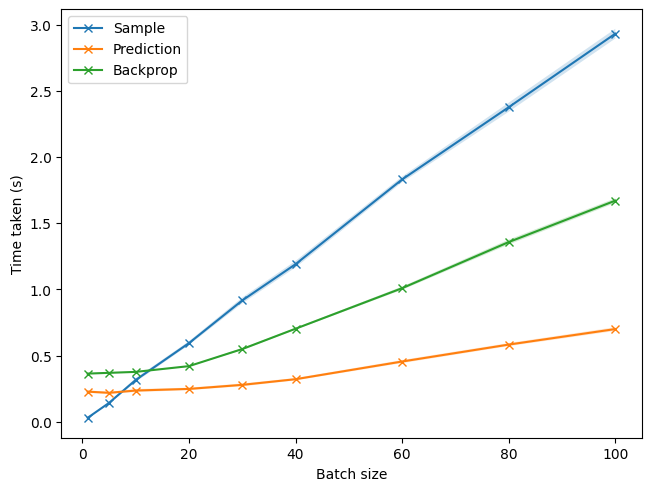

In [32]:
means = results.mean(axis=1)
std = results.std(axis=1, ddof=1)
sem = std / np.sqrt(results.shape[1])

labels = ["Sample", "Prediction", "Backprop"]

fig, ax = plt.subplots(layout="constrained")

for i in range(3):
    m = means[:, i]
    e = sem[:, i]
    ax.plot(Ns, m, label=labels[i], marker="x")
    ax.fill_between(Ns, m - e, m + e, alpha=0.2)

ax.set_xlabel("Batch size")
ax.set_ylabel("Time taken (s)")
ax.legend()
plt.show()

# Attempts at training an autoencoder

In [91]:
sample, _, _ = dataset.choose_events(100, 3)

In [102]:
patches = torch.tensor(np.concatenate([x[2] for s in sample for x in s])).float().to(device)

In [103]:
tokenizer = Tokenizer().to(device)

In [105]:
tokenizer(patches).shape

torch.Size([11421, 256])